In [2]:
%%capture
!pip -q install --upgrade folium
!apt install libspatialindex-dev
!pip -q install rtree
!pip -q install geopandas
!pip -q install geojson
!pip -q install geemap==0.17.3
!pip -q uninstall tornado -y
!yes | pip install tornado==5.1.0
!pip -q install rasterio
!pip -q install tqdm
!pip -q install eeconvert
!pip -q install fcntl

In [6]:
%%capture
%python -m pip install --upgrade pip

In [3]:
%%capture
%pip install eeconvert

In [3]:
%pip install ee



Defaulting to user installation because normal site-packages is not writeable
  Using cached blessings-1.7-py3-none-any.whl.metadata (19 kB)
Using cached blessings-1.7-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Standard imports
import os
from tqdm.notebook import tqdm
import requests
import json

import pandas as pd
import numpy as np
from PIL import Image

# Geospatial processing packages
import geopandas as gpd
import geojson

import shapely
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
from shapely.geometry import box

# Mapping and plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import ee
import eeconvert as eec
import geemap
import geemap.eefolium as emap
import folium

# Deep learning libraries
import torch
from torchvision import datasets, models, transforms

In [2]:
ee.Authenticate()
ee.Initialize(project="midyear-system-468814-r6")

In [3]:
ISO = 'NGA' # "DEU" is the ISO code for Germany
ADM = 'ADM1' # Equivalent to administrative districts

# Query geoBoundaries
url = f"https://www.geoboundaries.org/api/current/gbOpen/{ISO}/{ADM}"
r = requests.get(url)
download_path = r.json()["gjDownloadURL"]

# Save the result as a GeoJSON
filename = 'geoboundary.geojson'
geoboundary = requests.get(download_path).json()
with open(filename, 'w') as file:
   geojson.dump(geoboundary, file)

# Read data using GeoPandas
geoboundary = gpd.read_file(filename)
print("Data dimensions: {}".format(geoboundary.shape))
geoboundary.sample(8)

Data dimensions: (37, 6)


,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry
10,Delta,NG-DE,27671186B69086015704361,NGA,ADM1,"POLYGON ((6.48548 5.37921, 6.47656 5.40405, 6...."
15,Borno,NG-BO,27671186B753479316714,NGA,ADM1,"POLYGON ((11.83578 10.03389, 11.84447 10.03239..."
20,Anambra,NG-AN,27671186B76680224160916,NGA,ADM1,"POLYGON ((6.60187 5.68746, 6.626 5.68352, 6.65..."
33,Kaduna,NG-KD,27671186B54051914323789,NGA,ADM1,"POLYGON ((7.72408 9.32925, 7.73119 9.32614, 7...."
13,Kogi,NG-KO,27671186B96047513549152,NGA,ADM1,"POLYGON ((6.82789 8.45755, 6.82784 8.45716, 6...."
0,Cross River,NG-CR,27671186B81745654473385,NGA,ADM1,"POLYGON ((8.2743 4.85474, 8.29153 4.84805, 8.3..."
31,Bauchi,NG-BA,27671186B7584771598694,NGA,ADM1,"POLYGON ((10.54096 9.48354, 10.60423 9.46648, ..."
16,Katsina,NG-KT,27671186B99661334382691,NGA,ADM1,"POLYGON ((6.88944 11.38364, 6.89176 11.3834, 6..."


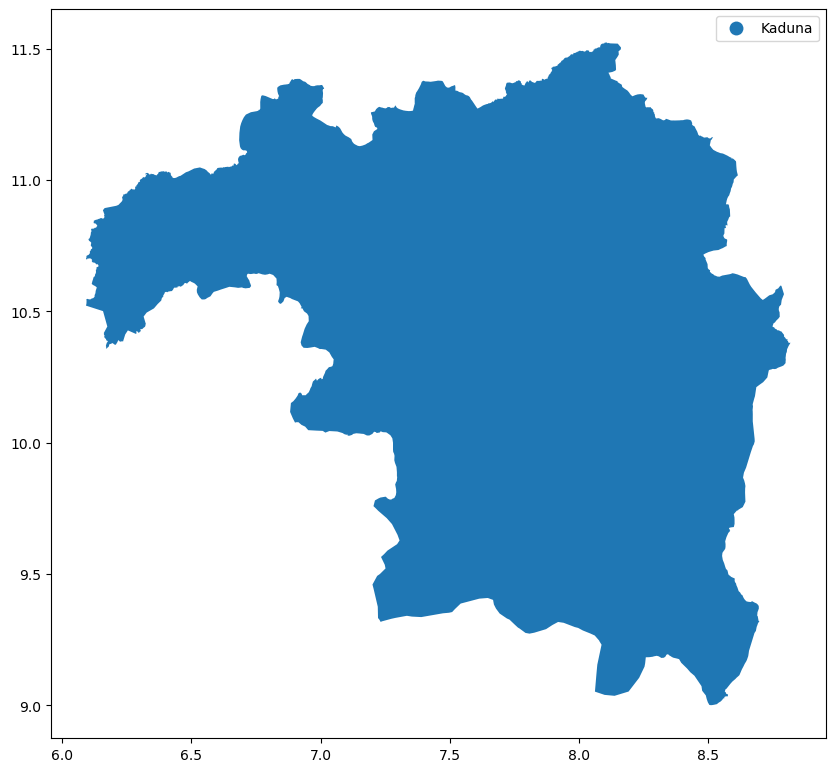

In [4]:
shape_name = 'Kaduna'
fig, ax = plt.subplots(1, figsize=(10,10))
geoboundary[geoboundary.shapeName == shape_name].plot('shapeName', legend=True, ax=ax);

In [5]:
def generate_image(
    region,
    product='COPERNICUS/S2',
    min_date='2018-01-01',
    max_date='2020-01-01',
    range_min=0,
    range_max=2000,
    cloud_pct=10
):

    """Generates cloud-filtered, median-aggregated
    Sentinel-2 image from Google Earth Engine using the
    Pythin Earth Engine API.

    Args:
      region (ee.Geometry): The geometry of the area of interest to filter to.
      product (str): Earth Engine asset ID
        You can find the full list of ImageCollection IDs
        at https://developers.google.com/earth-engine/datasets
      min_date (str): Minimum date to acquire collection of satellite images
      max_date (str): Maximum date to acquire collection of satellite images
      range_min (int): Minimum value for visalization range
      range_max (int): Maximum value for visualization range
      cloud_pct (float): The cloud cover percent to filter by (default 10)

    Returns:
      ee.image.Image: Generated Sentinel-2 image clipped to the region of interest
    """

    # Generate median aggregated composite
    image = ee.ImageCollection(product)\
        .filterBounds(region)\
        .filterDate(str(min_date), str(max_date))\
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_pct))\
        .median()

    # Get RGB bands
    image = image.visualize(bands=['B4', 'B3', 'B2'], min=range_min, max=range_max)
    # Note that the max value of the RGB bands is set to 65535
    # because the bands of Sentinel-2 are 16-bit integers
    # with a full numerical range of [0, 65535] (max is 2^16 - 1);
    # however, the actual values are much smaller than the max value.
    # Source: https://stackoverflow.com/a/63912278/4777141

    return image.clip(region)

In [6]:
# Get the shape geometry for Kreis Borken
region  = geoboundary.loc[geoboundary.shapeName == shape_name]
centroid = region.iloc[0].geometry.centroid.coords[0]
region = eec.gdfToFc(region) #geodataframe to feature collection

# Generate RGB image using GEE
image = generate_image(
    region,
    product='COPERNICUS/S2', # Sentinel-2A
    min_date='2021-01-01', # Get all images within
    max_date='2021-12-31', # the year 2021
    cloud_pct=10, # Filter out images with cloud cover >= 10.0%
)

# Visualize map
Map = emap.Map(center=[centroid[1], centroid[0]], zoom=10)
Map.addLayer(image, {}, 'Sentinel2')
Map.addLayerControl()
Map

C:\Users\HP PC\AppData\Roaming\Python\Python310\site-packages\ee\deprecation.py:209: DeprecationWarning: 

Attention required for COPERNICUS/S2! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2

  warnings.warn(warning, category=DeprecationWarning)
